<a href="https://colab.research.google.com/github/rajaonsonella/csc2541_lab1/blob/main/lab1_module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC2541 - Lab 1: Deep Learning for structure-based drug design (SBDD)

Structure-based drug design (SBDD) aims at designing small-molecule ligands that bind with high affinity and specificity to pre-determined protein targets which have been identified as having therapeutic potential. Specifically, this approach focuses on leveraging the 3D structure of the protein target to rationally design a ligand.

In this lab, we aim at giving you an introduction to SBDD and the latest deep learning models used in the field. The lab is structured into three parts

### Table of Content

1.   Pre-module: Introduction to the Protein Data Bank (PDB) (~30 mins)
2.   Module: Exploring how ML does at Ligand pose prediction (~50 mins)
3.   Post-module (assignment): Evaluating a state of the art ML model (Boltz2) on various protein ligand complex pose prediction (~60 mins)

# Colab Set Up

In [1]:
# Installing packaging necessary to run the notebook

from IPython.utils import io

!pip install -q condacolab
import condacolab
condacolab.install()

# An automatic restart of the kernel is expected after the execution of this block.
# Stay connected to the same runtime and proceed to the next code block!

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:07
🔁 Restarting kernel...


In [1]:
# Get environment configuration from Git Repository
setup_repo="https://github.com/rwxayheee/colab_setup"
!git clone {setup_repo}

# Run setup script
!chmod +x colab_setup/basic_setup.sh
!bash colab_setup/basic_setup.sh


# # Get environment configuration from Git Repository
# setup_repo="https://github.com/rajaonsonella/csc2541_lab1.git"
# !git clone {setup_repo}

# # Run setup script
# !chmod +x csc2541_lab1/setup.sh
# !bash csc2541_lab1/setup.sh

Cloning into 'colab_setup'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 75 (delta 30), reused 52 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 14.50 KiB | 14.50 MiB/s, done.
Resolving deltas: 100% (30/30), done.

[INFO] Step 1: Installing Python packages using Conda and Pip...

Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ | done

cctbx-base-2025.7    | 67.6 MB   | :   0% 0/1 [00:00<?, ?it/s]
pillow-11.3.0        | 41.1 MB   | :   0% 0/1 [00:00<?, ?it/s]

rdkit-2025.03.5      | 19.3 MB   | :   0% 0/1 [00:00<?, ?it/s]


prody-2.6.1          | 18.0 MB   | :   0% 0/1 [00:00<?, ?it/s]



scipy-1.16.1         | 16.2 MB   | :   0% 0/1 [00:00<?, ?it/s]




pandas-2.3.2         | 14.6 MB   | :   0% 0/1 [00:00<?, ?it/s]





icu-75.1             | 11.6 MB   | :   0% 0/1 [00:00<?, ?it/s]






librdkit-2025.03.5   | 9.6 MB    | :   0

In [1]:
# !conda install cctbx-base==2024.6

In [ ]:
from IPython.utils import io
print('Downloading necessary libraries...')
def install_libraries():
  !pip install py3Dmol
  !pip install biopython -q
  !pip install torch
  !pip install torch-geometric
  !pip install torch-cluster
  !pip install torch-scatter
  !pip install pyyaml
  !pip install e3nn==0.5.1
  !pip install spyrmsd
  !pip install biopandas -q
  !pip install useful_rdkit_utils
with io.capture_output() as captured:
  install_libraries()

In [7]:
!pip install rdkit
!pip install posebusters

In [8]:
import ipywidgets
from IPython.display import display

# Module: Predicting protein-ligand interactions

Now that we have seen how 3D protein-ligand data is usually stored and visualized, we can start thinking about how to exploit such data to discover new drugs *rationally*.

By this, we mean that instead of relying on purely trial-and-error methods in drug discovery, we can now **retrospectively** understand why this drug "works" by looking at how it complexes with a targeted protein, provided we have the experimental data. Even more exciting, if we understand how/why a certain ligand binds to a target protein, we can **prospectively** try to find new candidates using that knowledge.

The issues are that:
1. Obtaining this type of structural data is extremely hard
2. There are more drug-like molecules than starts in the universe

Therefore, we want to limit using experimental techniques and offload as much work as possible to computational techniques instead. Still, we are limited in how much compute we want to allocate to this *in silico* exploration. The usual rule of thumb is that the more precise a computational method is, the more it costs in computational time.

For the rest of this module, we are going to focus on 2 methods that are **computationally cheap** and used to predict how a ligand binds to a protein.




## Molecular Docking

The first method we are going to see is molecular docking. You can find a great review of the method [here](https://doi.org/10.1146/annurev-biochem-030222-120000) if you are interested in reading more about it.

Molecular docking frames the concept of protein ligand binding as a **prediction task**: Given the structure of the target protein and a compound of interest (the query molecule), predict a binding pose and its associated binding energy.

In short, we input:
* The 3D structure of the protein
* The ligand structure (either as a SMILES, or an initial 3D conformation)

and we obtain:
* The predicted 3D conformation

Most of the time, we need to provide an approximate guess of where the ligand will bind (a binding site). When the binding site is not specified, we refer to it as *blind docking*.





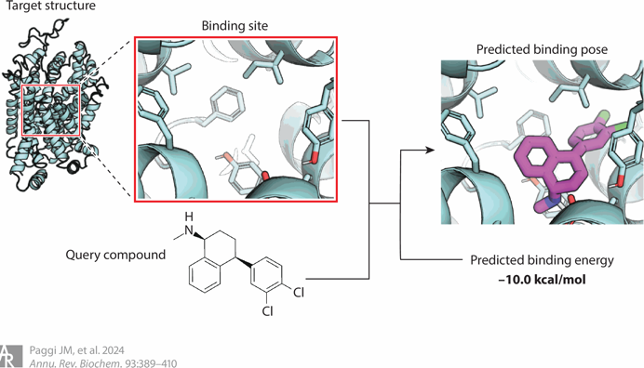

Molecular Docking involves involves two main stages:

1. Sampling: The algorithm explores many possible positions and orientations (or "poses") of the ligand within the receptor's active site. In AutoDock Vina, smina, and gnina, conformations are generated using Monte Carlo Sampling.
2. Scoring: Each generated pose is evaluated using a scoring function which estimates the binding affinity. The scoring function can be empirical, force-field based or even Deep Learning-based.
3. Poses are then ranked on these scores. For Vina scores, lower energy scores indicating more favorable interactions.

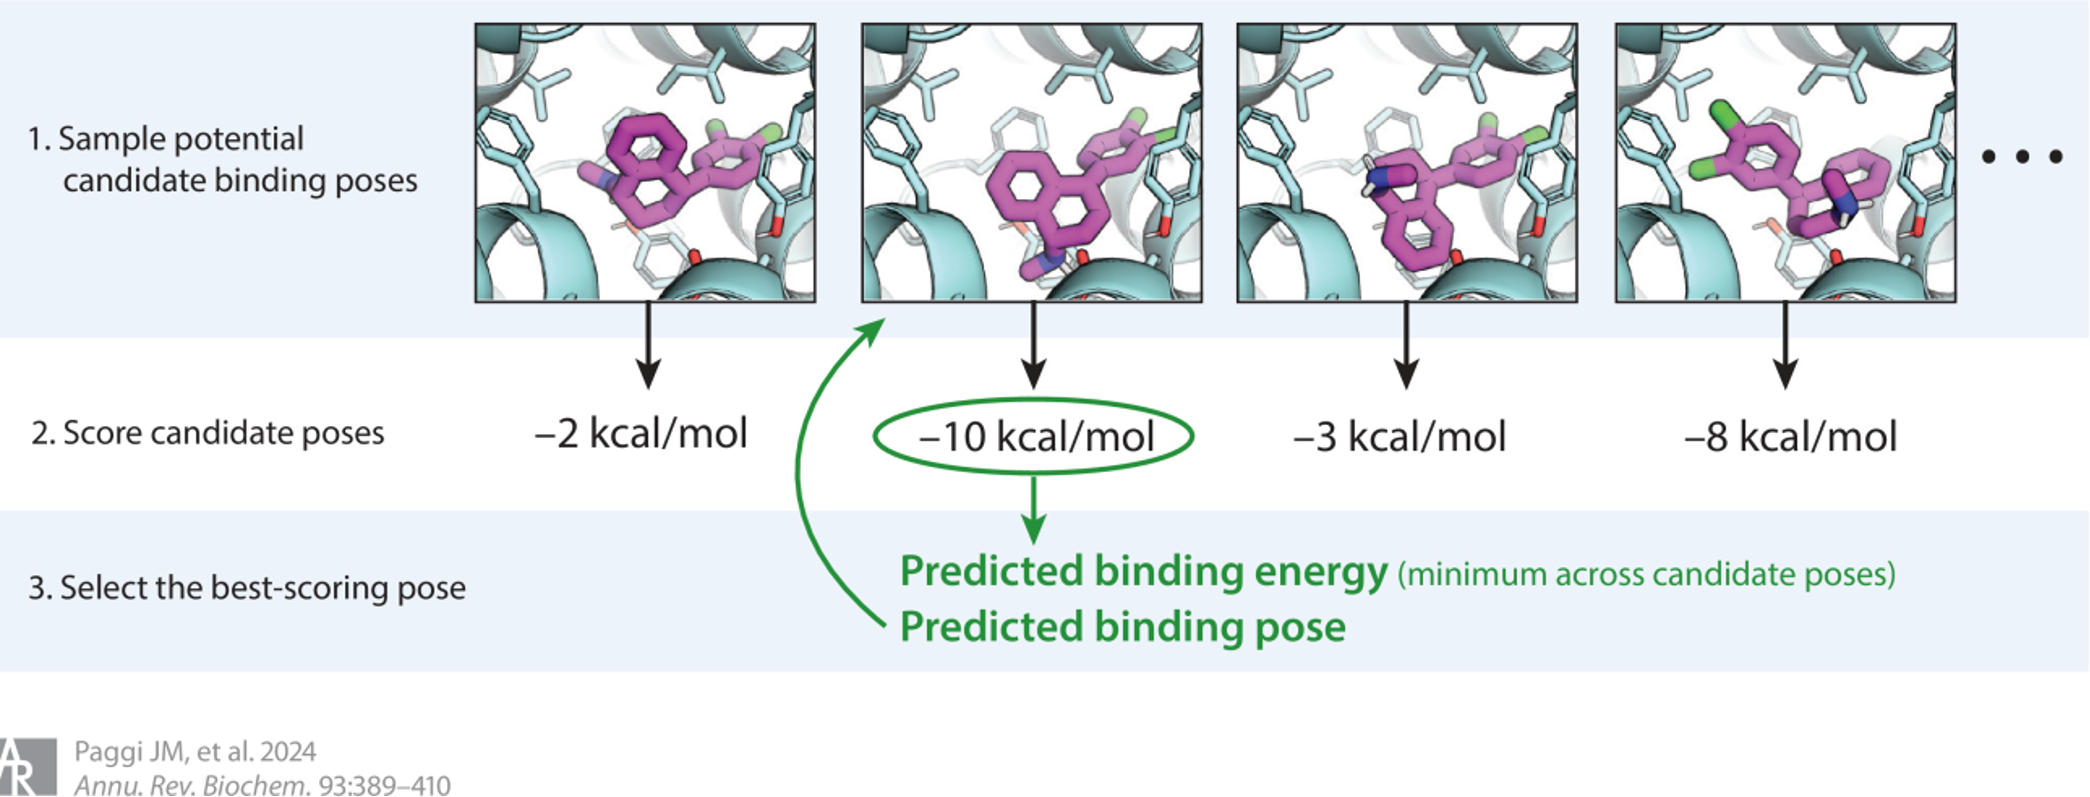

Here are an important point about Molecular Docking: It was developed to be fast so billions of molecules could be screened. That means that crude approximations are often made:

* The protein structure is usually **kept rigid** to simplify the interactions modeled. In reality, proteins are dynamic and can undergo conformational changes upon ligand binding. The ligand flexibility itself is limited!
* The scoring function are simplified at the benefit of speed, meaning they usually hold a good **discriminative** power, not necessarily a good *predictive* power: a good docking score means that the molecule is likely to bind to the protein, it does not means that the binding affinity of this molecule is correlated with the docking score.
* Most docking programs are NOT meant to be used in a blind docking fashion as their sampling procedure is optimized to work with the assumption a binding site will be provided.
* Docking simulations typically focus on binding affinity and pose prediction but often lack the biological context of the protein's environment, such as the presence of co-factors, metal ions, or allosteric regulation, which may influence the ligand binding.

Despite all of these assumptions, molecular docking remains an invaluable tool that is routinely used in drug discovery.

In the rest of this section, we are going to focus on a **re-docking** task, meaning we are going to evaluate how well a docking program's sampling algorithm and scoring function and reproduce a known experimental binding pose.

That means we need to quantitatively evaluate how close the known reference structure. The standard metric used for this comparison is the **Root Mean Square Deviation (RMSD)**. RMSD measures the average distance between corresponding atoms of two molecular structures. A lower RMSD value indicates greater similarity between the docked pose and the reference structure. Mathematically, it's calculated as:

$$
RMSD = ( \frac{1}{N} \sum_{i=1}^{N} \delta_i^2 )^{1/2}
$$


where $N$ is the number of corresponding atom pairs being compared, and $\delta_i$ is the Euclidean distance between the $i$-th pair of atoms.


In docking studies, a common threshold for considering a docked pose "successful" or accurate is an **RMSD below 2 Angstroms** compared to the crystal structure.


## Activity: re-docking a molecule with QVina

To perform a docking calculation, we usually need to prepare a bunch of files. Depending on the quality of the experimental protein structure, this may be more or less tedious: there can be missing residues or atoms, non-standard amino acids, water molecules, incomplete charge information etc.

This is what a typical docking procedure looks like:

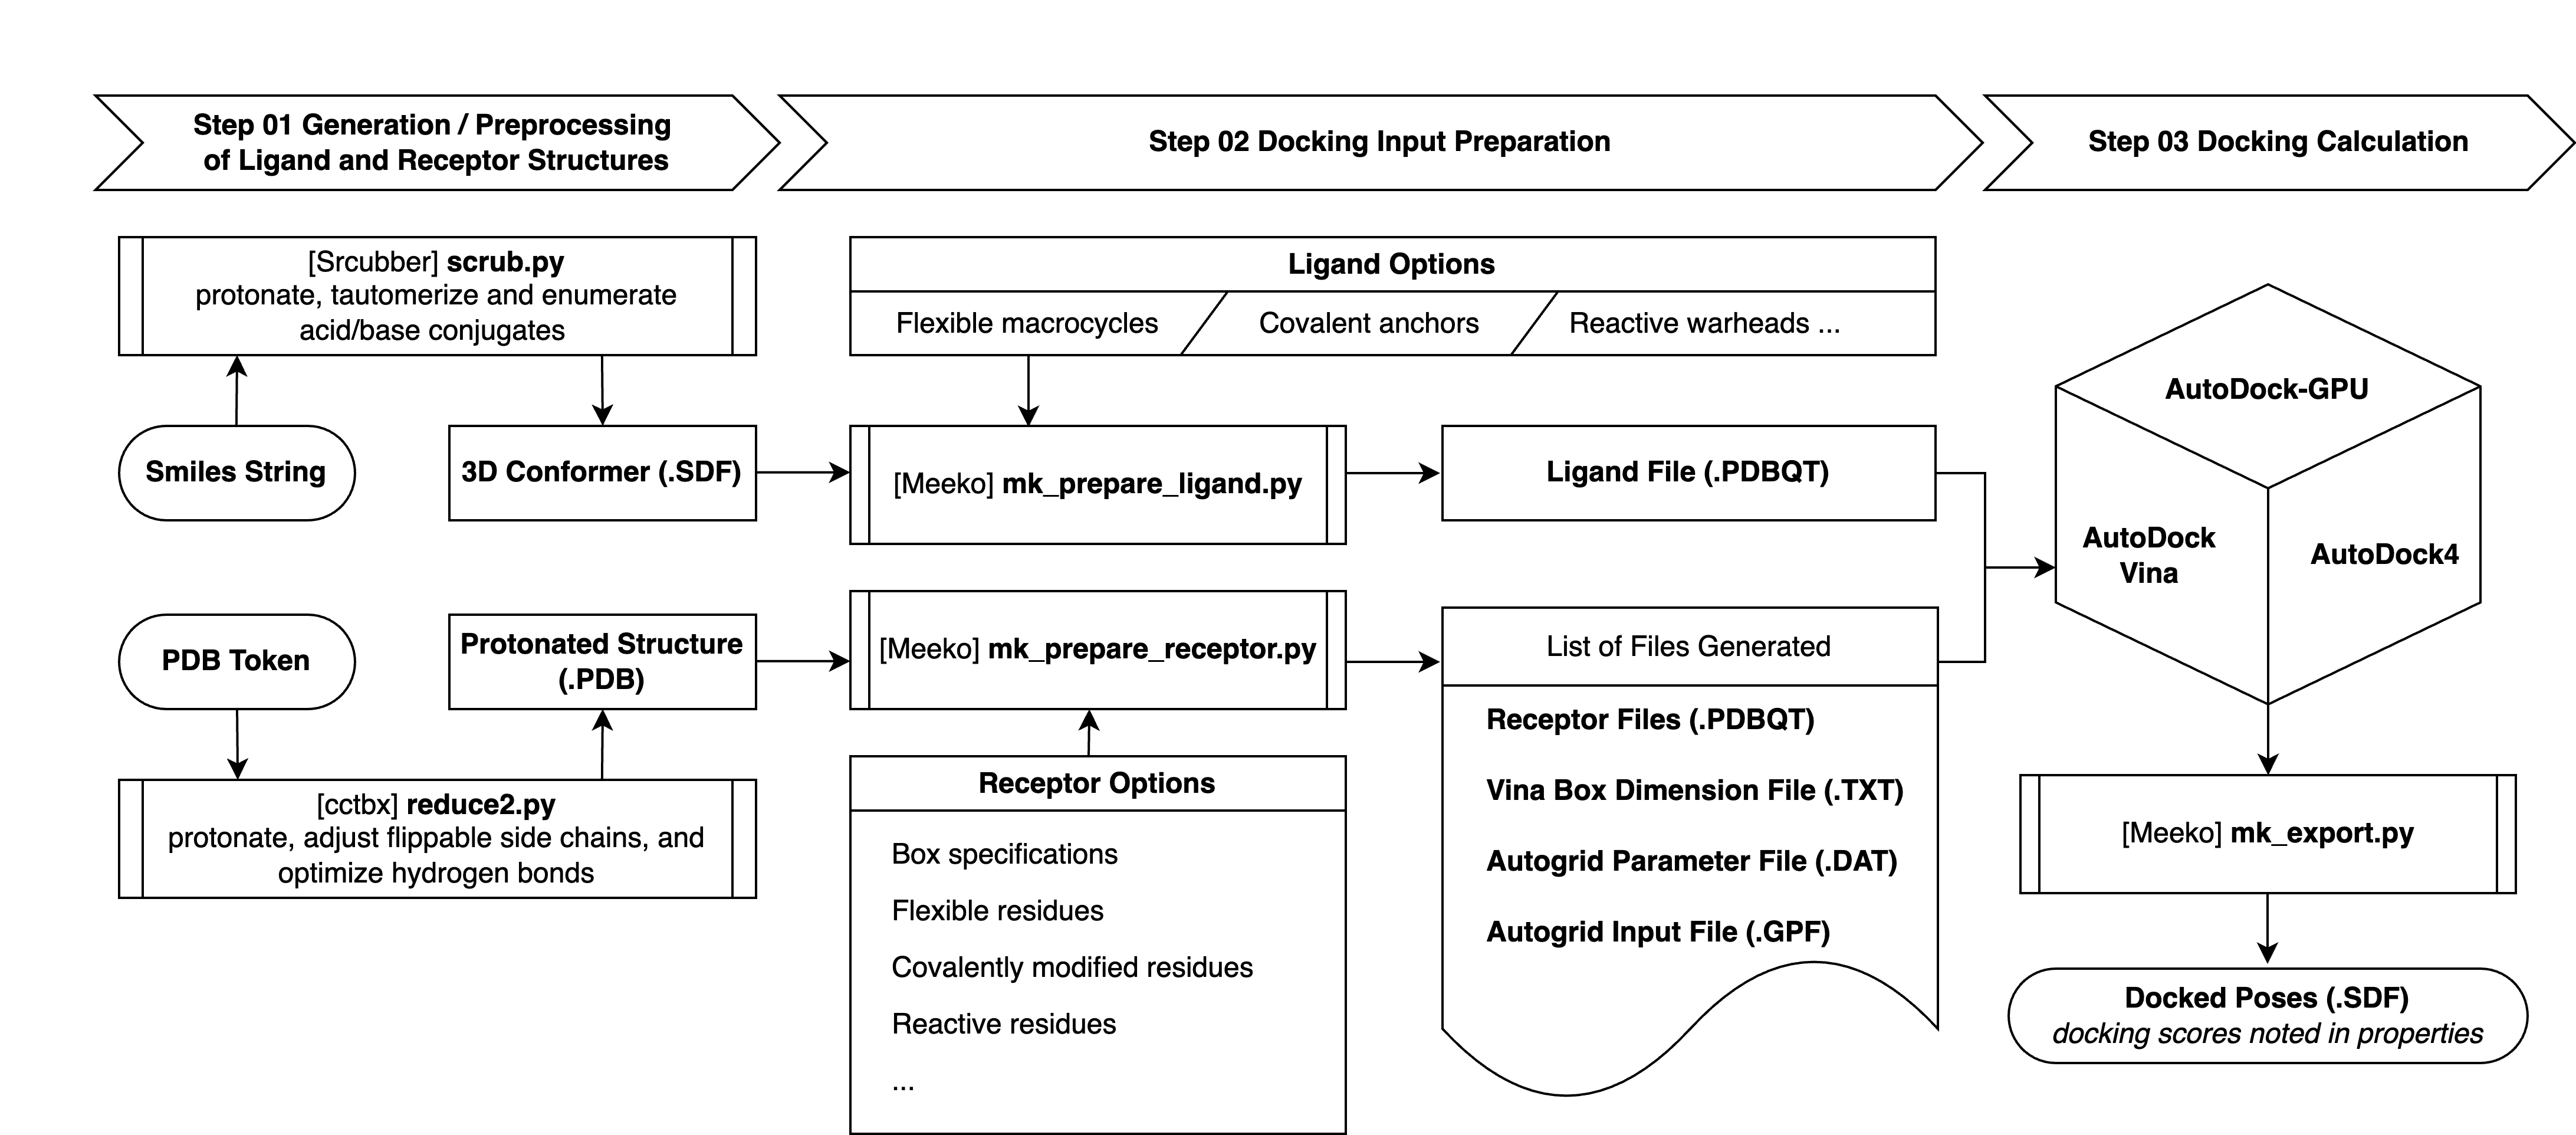

We will be going through those basics steps shortly!

### Logistics

For this lab, we are going to split into 2 groups


### Group 1:

> Ligand:
>
> * Name:
>
> * SMILES:
>
> Protein:
> * PDB ID:

### Group 2:

> Ligand:
>
> * Name:
>
> * SMILES:
>
> Protein:
> * PDB ID:

### Helper functions

In [9]:
# Import modules
import sys, platform
from prody import *
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit, py3Dmol
print("rdkit version:", rdkit.__version__)
print("py3Dmol version:", py3Dmol.__version__)
from ipywidgets import interact, IntSlider
import ipywidgets, copy
from IPython.display import display, Markdown


# Helper functions
def locate_file(from_path = None, query_path = None, query_name = "query file"):

    if not from_path or not query_path:
        raise ValueError("Must specify from_path and query_path")

    possible_path = list(from_path.glob(query_path))

    if not possible_path:
        raise FileNotFoundError(f"Cannot find {query_name} from {from_path} by {query_path}")

    # return_which = (
    #     f"using {query_name} at:\n"
    #     f"{possible_path[0]}\n"
    # )
    # print(return_which)

    return possible_path[0]

# Commandline scripts
scrub = locate_file(from_path = Path("/usr/local/bin"), query_path = "scrub.py", query_name = "scrub.py")
mk_prepare_ligand = locate_file(from_path = Path("/usr/local/bin"), query_path = "mk_prepare_ligand.py", query_name = "mk_prepare_ligand.py")
mk_prepare_receptor = locate_file(from_path = Path("/usr/local/bin"), query_path = "mk_prepare_receptor.py", query_name = "mk_prepare_receptor.py")
mk_export = locate_file(from_path = Path("/usr/local/bin"), query_path = "mk_export.py", query_name = "mk_export.py")


# Locate reduce2 in conda install prefix
full_py_version = platform.python_version()
major_and_minor = ".".join(full_py_version.split(".")[:2])
env_path = Path("/usr/local") # default conda install prefix on Colab
reduce2_path = f"lib/python{major_and_minor}/site-packages/mmtbx/command_line/reduce2.py"
reduce2 = locate_file(from_path = env_path, query_path = reduce2_path, query_name = "reduce2.py")


# Locate geostd in current path
geostd_path = locate_file(from_path = Path.cwd(), query_path = "geostd", query_name = "geostd")

ModuleNotFoundError: No module named 'rdkit'

In [10]:
import requests
import py3Dmol

# Download a PDB file
def download_pdb_file(pdb_id: str) -> str:
    # url or pdb_id
    if pdb_id.startswith('http'):
        url = pdb_id
        filename = url.split('/')[-1]
    elif pdb_id.endswith(".pdb"):
        return pdb_id
    else:
        if pdb_id.startswith("AF"):
            url = f"https://alphafold.ebi.ac.uk/files/{pdb_id}-model_v3.pdb"
        else:
            url = f"http://files.rcsb.org/view/{pdb_id}.pdb"
        filename = f'{pdb_id}.pdb'

    pdb_req = requests.get(url)
    pdb_req.raise_for_status()
    open(filename, 'w').write(pdb_req.text)
    return filename

# Visualization with py3Dmol
def Receptor3DView(receptorPDB = None, boxPDB = None, ligPDB = None):

    view = py3Dmol.view()
    view.setBackgroundColor('white')

    view.addModel(open(receptorPDB, 'r').read(),'pdb')
    view.addStyle({'cartoon': {'color':'spectrum', 'opacity': 0.5}})

    if boxPDB is not None:
      view.addModel(open(boxPDB, 'r').read(),'pdb')
      view.addStyle({'stick': {}})
      view.zoomTo()

    if ligPDB is not None:
      view.addModel(open(ligPDB, 'r').read(), 'pdb')
      view.addStyle({'hetflag': True}, {'stick': {}})

    return view

### Step 0: Visualize the re-docking task structure

### Step 1: Ligand preparation

In [ ]:
# @markdown In this step, the ligand molecule is prepared from a Smiles string. A protonated 3D conformer of ligand is generated by **scrub.py**, and the conversion to a tangible ligand PDBQT file is done by **mk_prepare_ligand.py**.
%%time

# @markdown > Enter the Smiles string of ligand. This will be used as input for ***molscrub*** to protonate and generate a 3D conformer of the ligand.
ligand_Smiles = "CC1=C(NC2=NC=CC(C3=CN=CC=C3)=N2)C=C(NC(C4=CC=C(CN5CCN(C)CC5)C=C4)=O)C=C1" #@param {type:"string"}

# @markdown > Below are some available options of ***molscrub*** to determine what protonation variants to be generated for the input ligand.

# @markdown > A designated pH is required, usually we default to 7
pH = 7 #@param {type:"raw"}
# @markdown > The following two options allow you to opt out from enumeration of tautomers or protomers.
# @markdown > In this the example, we will ask ***molscrub*** to perform acidbase enumeration only for the ligand.
args = ""
skip_tautomer = True #@param {type:"boolean"}
if skip_tautomer:
  args += "--skip_tautomer "
skip_acidbase = False #@param {type:"boolean"}
if skip_acidbase:
  args += "--skip_acidbase "
# @markdown With the above specifications, a 3D conformer of the protonated ligand will be generated by **scrub.py**.
# @markdown
# @markdown The SDF file is then fed to **mk_prepare_ligand.py** to generate the ligand PDBQT file.

# @markdown > A name for the ligand PDBQT file is required.
ligandPDBQT = "STI.pdbqt" #@param {type:"string"}


# Write scrubbed protomer(s) and conformer(s) to SDF
ligandName = ligandPDBQT.replace(".pdbqt", "")
ligandSDF = f"{ligandName}_scrubbed.sdf"
! python {scrub} "{ligand_Smiles}" -o {ligandSDF} --ph {pH} {args}


# Prepare ligand PDBQT
! python {mk_prepare_ligand} -i {ligandSDF} -o {ligandPDBQT}


# Visualization with py3Dmol
view = py3Dmol.view()
view.addModel(open(ligandSDF, 'r').read(),'sdf')
view.zoomTo()
view.setBackgroundColor('white')
view.addStyle({'stick': {'colorscheme':'yellowCarbon'}})
view.show()

### Step 2: Receptor Preparation

In [ ]:
%%time
#@markdown The preparation of a rigid receptor consists of two steps. The receptor structure is first sourced from a PDB file and sent to **reduce2.py** for hydrogen addition and optimization, and then, the conversion to a tangible receptor PDBQT file is done by **mk_prepare_receptor.py**.

#@markdown ## (1) Add Hydrogens to Receptor with Reduce2

# @markdown > Enter the PDB ID here to source the starting structure of receptor. This PDB file will be pulled from RCSB PDB server.
# Download PDB file
pdb_token = "1iep" #@param {type:"string"}
download_pdb_file(pdb_token)


# Export receptor atoms
atoms_from_pdb = parsePDB(pdb_token)
# @markdown > Use ProDy selection language to specify atoms to retain in receptor.
receptor_selection = "chain A and not water and not hetero" #@param {type:"string"}
receptor_atoms = atoms_from_pdb.select(receptor_selection)
prody_receptorPDB = f"{pdb_token}_receptor_atoms.pdb"
writePDB(prody_receptorPDB, receptor_atoms)


# Add CRYST1 card (temporarily required for reduce2)
reduce_inputPDB = f"{pdb_token}_receptor.pdb"
! cat <(grep "CRYST1" "{pdb_token}.pdb") {prody_receptorPDB} > {reduce_inputPDB}


# Run reduce2
# @markdown > Use PHIL arguments to specify the tasks for reduce2. In this example, we use `approach=add add_flip_movers=True` which is equivalent to `-build` or `-flip` in the formerly standalone reduce. These arguments ask ***reduce*** to allow NQH flips and build histidines to neutral tautomers while adding hydrogens.
reduce_opts = "approach=add add_flip_movers=True" #@param {type:"string"}
import os
os.environ["MMTBX_CCP4_MONOMER_LIB"] = str(geostd_path)
!echo $MMTBX_CCP4_MONOMER_LIB
!python {reduce2} {reduce_inputPDB} {reduce_opts}

print(reduce2)
print(reduce_inputPDB)
print(reduce_opts)
# Default name of reduce output...
prepare_inPDB = f"{pdb_token}_receptorFH.pdb"

#@markdown ---
#@markdown ## (2) Receptor Preparation with Meeko

# Specify Box
# Center at ligand
atoms_from_pdb = parsePDB(pdb_token)
#@markdown > Use ProDy selection language to specify (ligand, residue, or any) atoms for box center calculation. In this example, we choose the ligand and will use the geometric center of ligand as box center.
ligand_selection = "chain A and resname STI" #@param {type:"string"}
ligand_atoms = atoms_from_pdb.select(ligand_selection)
center_x, center_y, center_z = calcCenter(ligand_atoms)


#@markdown > Export ligand's original position to a PDB file. This is totally optional, but we will do it for visualization.
prody_ligandPDB = "LIG.pdb" #@param {type:"string"}
writePDB(prody_ligandPDB, ligand_atoms)


# Size in each dimension
#@markdown > Enter the box size (Å) of box in each dimension
size_x = 20.0 #@param {type:"raw"}
size_y = 20.0 #@param {type:"raw"}
size_z = 20.0 #@param {type:"raw"}


# @markdown With the above specifications, atom selection will be made on the original PDB file in ***ProDy***. Then, a protonated structure is generated by **reduce2.py**.
# @markdown
# @markdown The PDB file is then fed to **mk_prepare_receptor.py** to generate the receptor PDBQT file.

# Prepare Receptor
# @markdown > A basename for the receptor PDBQT file is required.
prepare_output = "1iep_receptorFH" #@param {type:"string"}
! python {mk_prepare_receptor} -i {prepare_inPDB} -o {prepare_output} -p -v --box_center {center_x} {center_y} {center_z} --box_size {size_x} {size_y} {size_z}


Receptor3DView(receptorPDB = prepare_inPDB, \
               boxPDB = prepare_output+'.box.pdb', \
               ligPDB = prody_ligandPDB).show()

### Step 3: Docking with Vina

In [ ]:
%%time
#@markdown In this step, the docking calculation is executed by ***Vina***.

#@markdown > Specify the names of inputs. You may include any additional options in `configTXT`.
receptorPDBQT = "1iep_receptorFH.pdbqt" #@param {type:"string"}
ligandPDBQT = "STI.pdbqt" #@param {type:"string"}
configTXT = "1iep_receptorFH.box.txt" #@param {type:"string"}
#@markdown > Specify the exhaustiveness of docking. In this example, we use a relatively low `exhaustiveness = 8` for demonstration purposes.
exhaustiveness = 8 #@param {type:"raw"}
#@markdown > A name for the docking output PDBQT file is required.
outputPDBQT = "1iep_STI_vina_out.pdbqt" #@param {type:"string"}

! vina --receptor {receptorPDBQT} --ligand {ligandPDBQT} --config {configTXT} \
       --exhaustiveness {exhaustiveness} \
       --out {outputPDBQT}

### Step 4: Export and Visualize Docked Poses

In [ ]:
%%time
#@markdown In this step, the docking output is converted to atomistic SDF by **mk_export.py**.

# Export Docked Poses
#@markdown > A name for the result SDF file is required.
dock_outSDF = "1iep_STI_vina_out.sdf" #@param {type:"string"}
! python {mk_export} {outputPDBQT} -s {dock_outSDF}

#@markdown > Finally (and optionally) for visualization:
#@markdown >
#@markdown > The ***Py3DMol*** view will include object from the following files and specs:
# Previously Generated Receptor Files
receptorPDB = "1iep_receptorFH.pdb" #@param {type:"string"}
boxPDB = "1iep_receptorFH.box.pdb" #@param {type:"string"}
refligPDB = 'LIG.pdb' #@param {type:"string"}
reflig_resn = 'STI' #@param {type:"string"}

# Visualize Docked Poses
def Complex3DView(view, ligmol = None, refligPDB = None, reflig_resn = None):

    new_viewer = copy.deepcopy(view)

    mblock = Chem.MolToMolBlock(ligmol)
    new_viewer.addModel(mblock, 'mol')
    new_viewer.addStyle({'hetflag': True}, {"stick": {'colorscheme': 'greenCarbon'}})

    if refligPDB is not None and reflig_resn is not None:
      new_viewer.addModel(open(refligPDB, 'r').read(), 'pdb')
      new_viewer.addStyle({'resn': reflig_resn}, {"stick": {'colorscheme': 'magentaCarbon', 'opacity': 0.8}})

    return new_viewer


confs = Chem.SDMolSupplier(dock_outSDF)

def conf_viewer(idx):
    mol = confs[idx]
    return Complex3DView(Receptor3DView(receptorPDB = receptorPDB, boxPDB = boxPDB), \
                         mol, \
                         refligPDB = refligPDB, reflig_resn = reflig_resn).show()


interact(conf_viewer, idx=ipywidgets.IntSlider(min=0, max=len(confs)-1, step=1))

### Step 5: Calculate RMSD

In [ ]:
import useful_rdkit_utils as uru
from rdkit import Chem

cognate = Chem.MolFromMolFile("docking_files/ligand_structures/Y6J_corrected_pose.sdf")
poses = Chem.SDMolSupplier("docking_results/Y6J_docked_7LME.sdf")

for i, pose in enumerate(poses):
    n_match, rmsd = uru.mcs_rmsd(cognate, pose)
    print(f"{n_match}\t{rmsd:.2f}")

## Shortcomings of Molecular Docking

## DiffDock

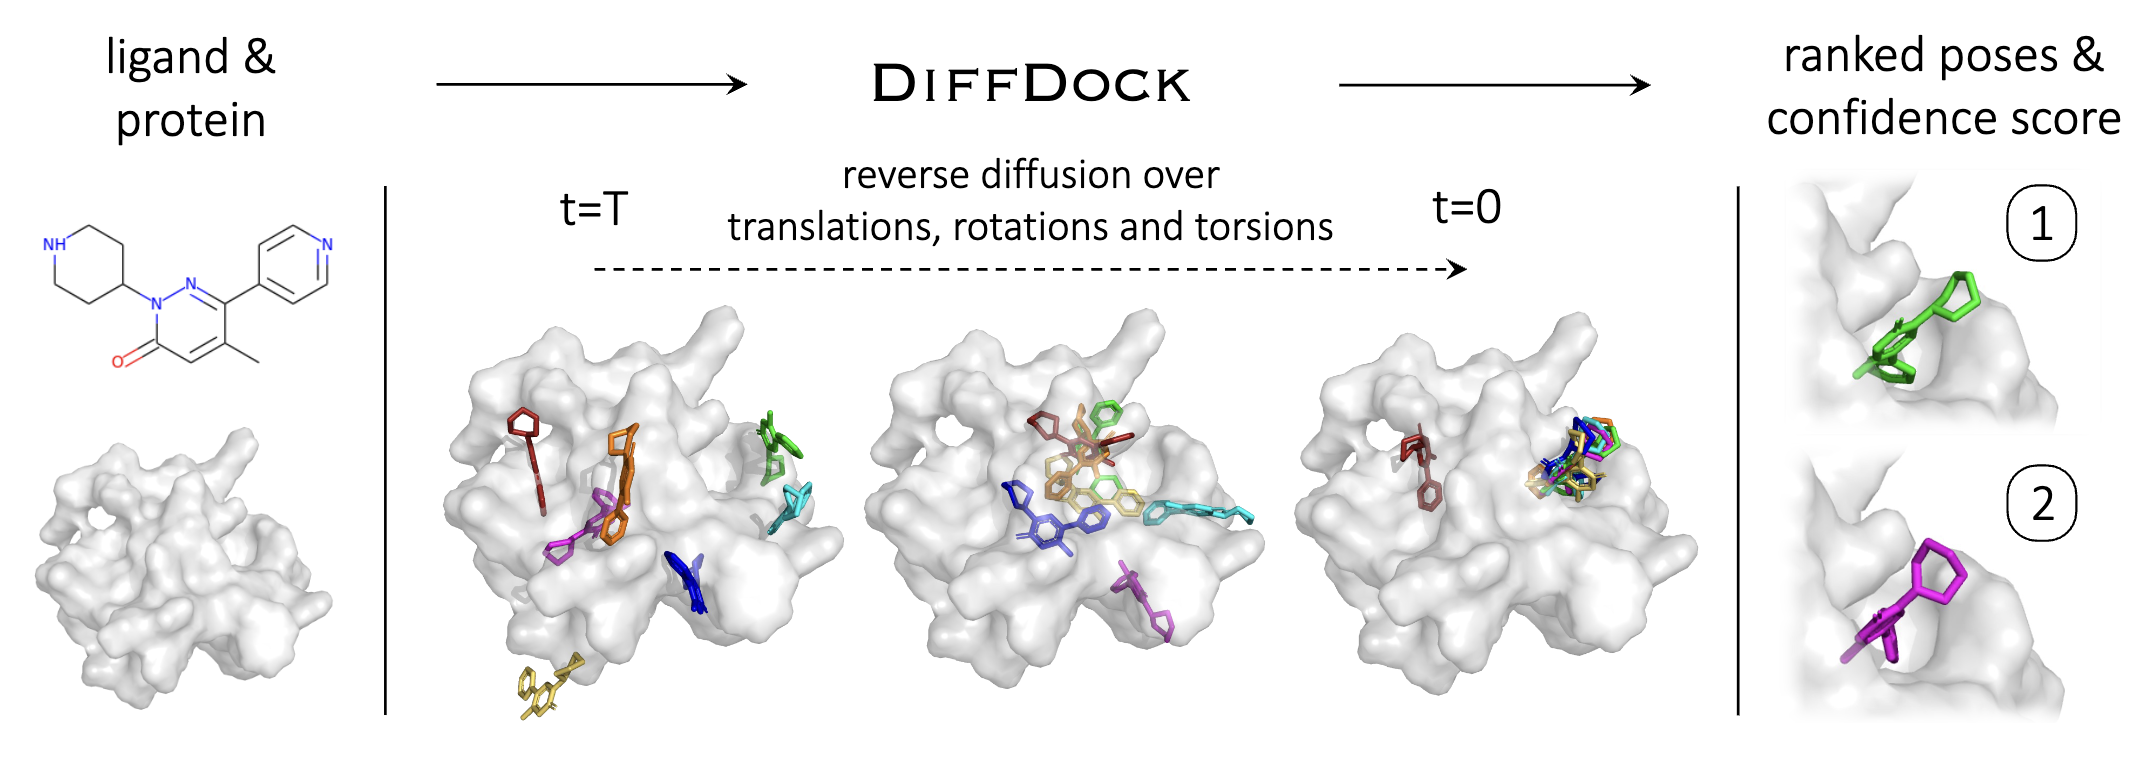

## Activity: "re-docking" a molecule with DiffDock

### Installation

In [ ]:
import os
if not os.path.exists("/content/DiffDock"):
    %cd /content
    !git clone https://github.com/gcorso/DiffDock.git
    %cd /content/DiffDock
    # Fix checkpoint to version before DiffDock-L
    !git checkout a6c5275

if not os.path.exists("/content/DiffDock/esm"):
    %cd /content/DiffDock
    !git clone https://github.com/facebookresearch/esm
    %cd /content/DiffDock/esm
    !git checkout ca8a710 # remove/update for more up to date code
    !sudo pip install -e .
    %cd /content/DiffDock

%cd /content/DiffDock
!python datasets/esm_embedding_preparation.py --protein_ligand_csv ./input_protein_ligand.csv --out_file data/prepared_for_esm.fasta

%cd /content/DiffDock
%env HOME=esm/model_weights
%env PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
!python /content/DiffDock/esm/scripts/extract.py esm2_t33_650M_UR50D data/prepared_for_esm.fasta data/esm2_output --repr_layers 33 --include per_tok --truncation_seq_length 30000

### CSV preparation

In [ ]:
# Format the input CSV for DiffDock
with open("./input_protein_ligand.csv", 'w') as out:
    out.write("protein_path,ligand\n")
    for pdb_file in pdb_files:
        for smiles in smiless:
            out.write(f"{pdb_file},{smiles}\n")

## What makes a predicted pose a good pose?

So far, we have only thought about assessing the validity of the protein-ligand complex prediction through RMSD. **While RMSD is a commonly used metric for assessing docking pose predictions, it's not the only factor that determines whether a predicted pose is truly accurate!**

Take a moment to think about other factors that matters when assessing the validity of a ligand pose!

Hint: Try to think about small changes that could be done to the molecule that would have tremendous chemical importance, but little geometrical importance

### Beyond RMSD

PoseBusters provides a more comprehensive evaluation by considering multiple metrics beyond just RMSD. These additional metrics help identify subtle issues, like side-chain clashes, incorrect bond angles, or geometric distortions, which RMSD alone might overlook. By using a combination of these metrics, PoseBusters ensures a more thorough validation of your protein pose, giving you a clearer understanding of its quality and reliability. So, while RMSD is a useful starting point, be sure to check other key factors to get the full picture of how good your predicted pose really is.

#### Chemical validity and consistency

| **Test Name**                   | **Description**                                                                                                                                                                                                                                                                                                                                                               |
|--------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| File loads                     | The input molecule can be loaded into a molecule object by RDKit.                                                                                                                                                                                                                                                                                                            |
| Sanitisation                   | The input molecule passes RDKit’s chemical sanitisation checks.                                                                                                                                                                                                                                                                                                               |
| Molecular formula              | The molecular formula of the input molecule is the same as that of the true molecule.                                                                                                                                                                                                                                                                                         |
| Bonds                         | The bonds in the input molecule are the same as in the true molecule.                                                                                                                                                                                                                                                                                                        |
| Tetrahedral chirality         | The specified tetrahedral chirality in the input molecule is the same as in the true molecule.                                                                                                                                                                                                                                                                                |
| Double bond stereochemistry   | The specified double bond stereochemistry in the input molecule is the same as in the true molecule.                                                                                                                                                                                                                                                                         |


#### Intramolecular validity

| **Test Name**                   | **Description**                                                                                                                                                                                                                                                                                                                                                               |
|--------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Bond lengths                  | The bond lengths in the input molecule are within 0.75 of the lower and 1.25 of the upper bounds determined by distance geometry.                                                                                                                                                                                                                                          |
| Bond angles                   | The angles in the input molecule are within 0.75 of the lower and 1.25 of the upper bounds determined by distance geometry.                                                                                                                                                                                                                                                 |
| Planar aromatic rings         | All atoms in aromatic rings with 5 or 6 members are within 0.25 Å of the closest shared plane.                                                                                                                                                                                                                                                                                 |
| Planar double bonds           | The two carbons of aliphatic carbon-carbon double bonds and their four neighbours are within 0.25 Å of the closest shared plane.                                                                                                                                                                                                                                             |
| Internal steric clash         | The interatomic distance between pairs of non-covalently bound atoms is above 0.8 of the lower bound determined by distance geometry.                                                                                                                                                                                                                                        |
| Energy ratio                  | The calculated energy of the input molecule is no more than 100 times the average energy of an ensemble of 50 conformations generated for the input molecule.|


#### Intermolecular validity

| **Test Name**                         | **Description**                                                                                                                                                                                                                                                       |
|--------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Minimum protein-ligand distance       | The distance between protein-ligand atom pairs is larger than 0.75 times the sum of the pairs van der Waals radii.                                                                                                                                                    |
| Minimum distance to organic cofactors | The distance between ligand and organic cofactor atoms is larger than 0.75 times the sum of the pairs van der Waals radii.                                                                                                                                             |
| Minimum distance to inorganic cofactors | The distance between ligand and inorganic cofactor atoms is larger than 0.75 times the sum of the pairs covalent radii.                                                                                                                                               |
| Volume overlap with protein            | The share of ligand volume that intersects with the protein is less than 7.5%. The volumes are defined by the van der Waals radii around the heavy atoms scaled by 0.8.                                                                                               |
| Volume overlap with organic cofactors | The share of ligand volume that intersects with organic cofactors is less than 7.5%. The volumes are defined by the van der Waals radii around the heavy atoms scaled by 0.8.                                                                                         |
| Volume overlap with inorganic cofactors | The share of ligand volume that intersects with inorganic cofactors is less than 7.5%. The volumes are defined by the van der Waals radii around the heavy atoms scaled by 0.5.                                                                                         |

## Activity: Running PoseBusters on our predictions

### Checking Vina prediction

In [ ]:
!bust ligand_pred.sdf -l mol_true.sdf -p protein.pdb

### Checking DiffDock prediction

In [ ]:
!bust ligand_pred.sdf -l mol_true.sdf -p protein.pdb

### Discussion between groups

Congratulations, you have successfully completed all the activities in this module! 🎊

Now take some time to compare the metrics you obtained with someone from the opposite group: Is there a drastic difference? If so, what could be the cause of this discrepancy?